In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split as tts 

In [2]:
ccd = pd.read_csv('../input/call-center-data/Call Center Data.csv')
ccd.head()

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,1,217,204,94.01%,13,0:00:17,0:02:14,0:02:45,76.28%
1,2,200,182,91.00%,18,0:00:20,0:02:22,0:06:55,72.73%
2,3,216,198,91.67%,18,0:00:18,0:02:38,0:03:50,74.30%
3,4,155,145,93.55%,10,0:00:15,0:02:29,0:03:12,79.61%
4,5,37,37,100.00%,0,0:00:03,0:02:06,0:00:35,97.30%


In [3]:
ccd.dtypes

Index                          int64
Incoming Calls                 int64
Answered Calls                 int64
Answer Rate                   object
Abandoned Calls                int64
Answer Speed (AVG)            object
Talk Duration (AVG)           object
Waiting Time (AVG)            object
Service Level (20 Seconds)    object
dtype: object

In [4]:
ccd.describe

<bound method NDFrame.describe of       Index  Incoming Calls  Answered Calls Answer Rate  Abandoned Calls  \
0         1             217             204      94.01%               13   
1         2             200             182      91.00%               18   
2         3             216             198      91.67%               18   
3         4             155             145      93.55%               10   
4         5              37              37     100.00%                0   
...     ...             ...             ...         ...              ...   
1246   1247             191             184      96.34%                7   
1247   1248             212             209      98.58%                3   
1248   1249             210             203      96.67%                7   
1249   1250             167             159      95.21%                8   
1250   1251              12              11      91.67%                1   

     Answer Speed (AVG) Talk Duration (AVG) Waiting T

Removing the index data, since this is unecessary for further analysis. 

In [5]:
ccd = ccd.drop(['Index'], axis=1)
ccd.head()

,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,217,204,94.01%,13,0:00:17,0:02:14,0:02:45,76.28%
1,200,182,91.00%,18,0:00:20,0:02:22,0:06:55,72.73%
2,216,198,91.67%,18,0:00:18,0:02:38,0:03:50,74.30%
3,155,145,93.55%,10,0:00:15,0:02:29,0:03:12,79.61%
4,37,37,100.00%,0,0:00:03,0:02:06,0:00:35,97.30%


In order to review the correlation between all fields, some data needs to be manipulated.  There are several fields that are objects, and these need to be converted into numeric data (float) in order to determine how they relate to other fields in the dataframe. 

In [6]:
# Data Cleaning/Conversion 

ccd_time = ccd

# Convertine to datetime values 
ccd_time['Answer Speed (AVG)'] = pd.to_datetime(ccd_time['Answer Speed (AVG)'])
ccd_time['Talk Duration (AVG)'] = pd.to_datetime(ccd_time['Talk Duration (AVG)']) 
ccd_time['Waiting Time (AVG)'] = pd.to_datetime(ccd_time['Waiting Time (AVG)'])

#Converting datetime values into decimals for the hours, minutes, and seconds in order to have useable statistical (float) data 
ccd_time['Answer Speed (AVG)'] =  ccd_time['Answer Speed (AVG)'].dt.hour * 60 + ccd_time['Answer Speed (AVG)'].dt.minute + ccd_time['Answer Speed (AVG)'].dt.second/60
ccd_time['Talk Duration (AVG)'] = ccd_time['Talk Duration (AVG)'].dt.hour * 60 + ccd_time['Talk Duration (AVG)'].dt.minute + ccd_time['Talk Duration (AVG)'].dt.second/60
ccd_time['Waiting Time (AVG)'] = ccd_time['Waiting Time (AVG)'].dt.hour * 60 + ccd_time['Waiting Time (AVG)'].dt.minute + ccd_time['Waiting Time (AVG)'].dt.second/60


# Verifying changes have worked in our transition 
ccd_time.dtypes




Incoming Calls                  int64
Answered Calls                  int64
Answer Rate                    object
Abandoned Calls                 int64
Answer Speed (AVG)            float64
Talk Duration (AVG)           float64
Waiting Time (AVG)            float64
Service Level (20 Seconds)     object
dtype: object

To complete the cleaning of the data, the '%' sign needs to be remove from both the Answer Rate and Service Level (20 Seconds) fields.  This is preventing the conversion of these fields from object (above) to a float (below). 

In [7]:
# Changing percentage columns -- Answer Rate and Service Level (20 Seconds) to a float type 
ccd_time['Answer Rate'] = ccd_time['Answer Rate'].str.replace('%','')
ccd_time['Answer Rate'] = ccd_time['Answer Rate'].astype(float)

ccd_time['Service Level (20 Seconds)'] = ccd_time['Service Level (20 Seconds)'].str.replace('%','')
ccd_time['Service Level (20 Seconds)'] = ccd_time['Service Level (20 Seconds)'].astype(float)

# Validating all changes complete
ccd_time.dtypes

Incoming Calls                  int64
Answered Calls                  int64
Answer Rate                   float64
Abandoned Calls                 int64
Answer Speed (AVG)            float64
Talk Duration (AVG)           float64
Waiting Time (AVG)            float64
Service Level (20 Seconds)    float64
dtype: object

Now that the data has been cleaned, I'll look for null values in the dataset. 

In [8]:
ccd_time.isnull().sum()

Incoming Calls                0
Answered Calls                0
Answer Rate                   0
Abandoned Calls               0
Answer Speed (AVG)            0
Talk Duration (AVG)           0
Waiting Time (AVG)            0
Service Level (20 Seconds)    0
dtype: int64

Since there are no null/nan values within the dataset, visualization of the data below starts with a high-level view of the various fields as a histogram.  This is helpful to determine where incoming call volume is going, and how the various fields are grouped (in terms of aggregate volume). 

array([[<AxesSubplot:title={'center':'Incoming Calls'}>,
        <AxesSubplot:title={'center':'Answered Calls'}>,
        <AxesSubplot:title={'center':'Answer Rate'}>],
       [<AxesSubplot:title={'center':'Abandoned Calls'}>,
        <AxesSubplot:title={'center':'Answer Speed (AVG)'}>,
        <AxesSubplot:title={'center':'Talk Duration (AVG)'}>],
       [<AxesSubplot:title={'center':'Waiting Time (AVG)'}>,
        <AxesSubplot:title={'center':'Service Level (20 Seconds)'}>,
        <AxesSubplot:>]], dtype=object)

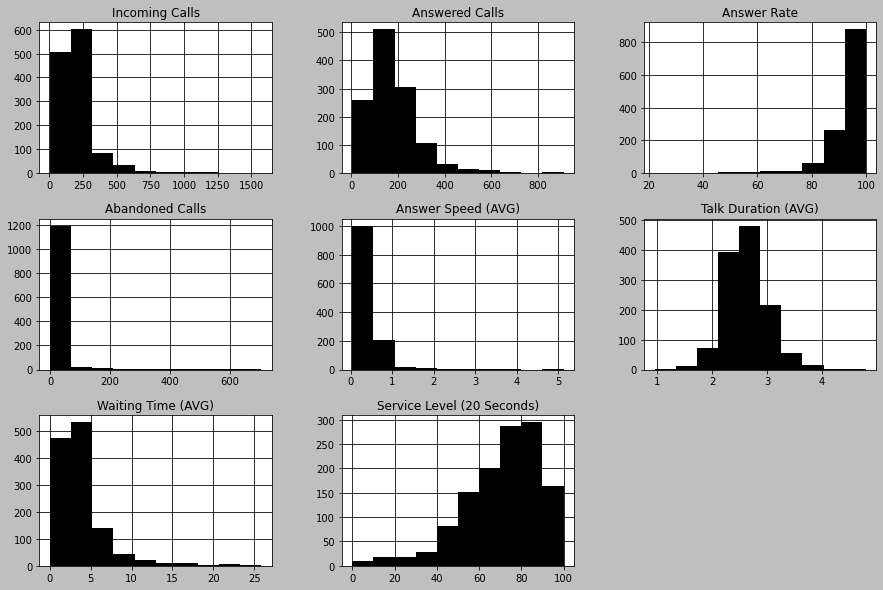

In [9]:
plt.style.use('grayscale')
ccd_time.hist(figsize=(15,10))


Beyond the above, since the nulls and incorrect formatting has been corrected, I can now run a heatmap/correlogram using to determine more meaningful relationships between the various data fields.  

<AxesSubplot:>

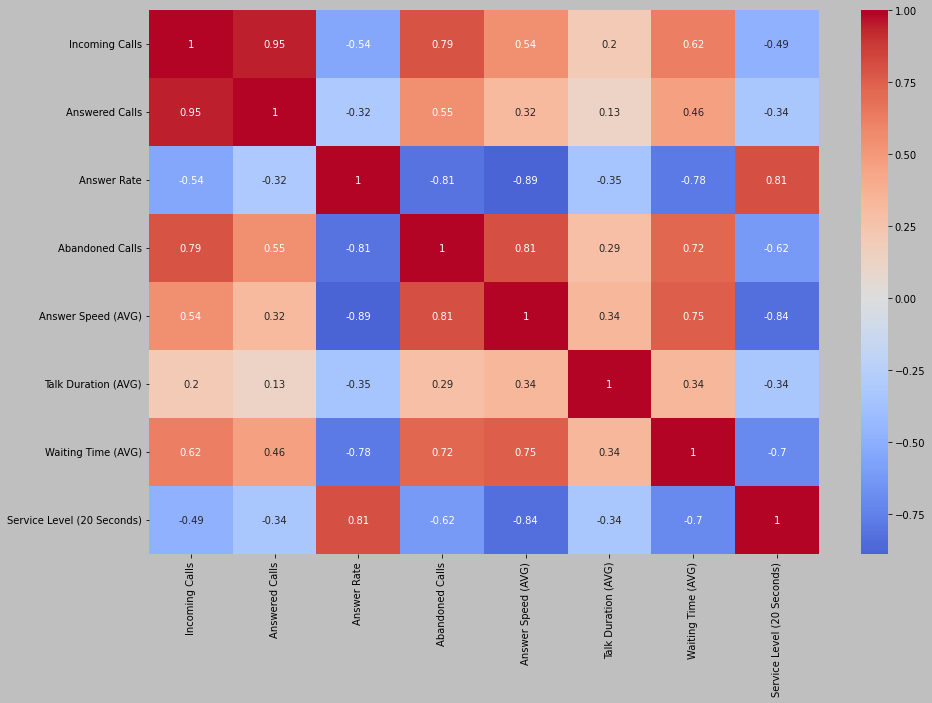

In [10]:
plt.figure(figsize=(15,10)) 
sns.color_palette("dark", as_cmap=True)
sns.heatmap(ccd_time.corr(), annot=True, cmap='coolwarm', center = 0)

The below helps to clearly indicate that wait time, rather than call volume, is a key driver in abandonment in calls.   While there is a relationship between these fields generally, overall, if there are a lot of calls answered quickly, there is less of an impact on abandonment.  Additionally, there is a significant increase in abandonment when wait time exceeds 15 minutes and call volume exceeds 800 calls. 

Text(0.5, 1.0, 'Incoming Calls and Abandonment')

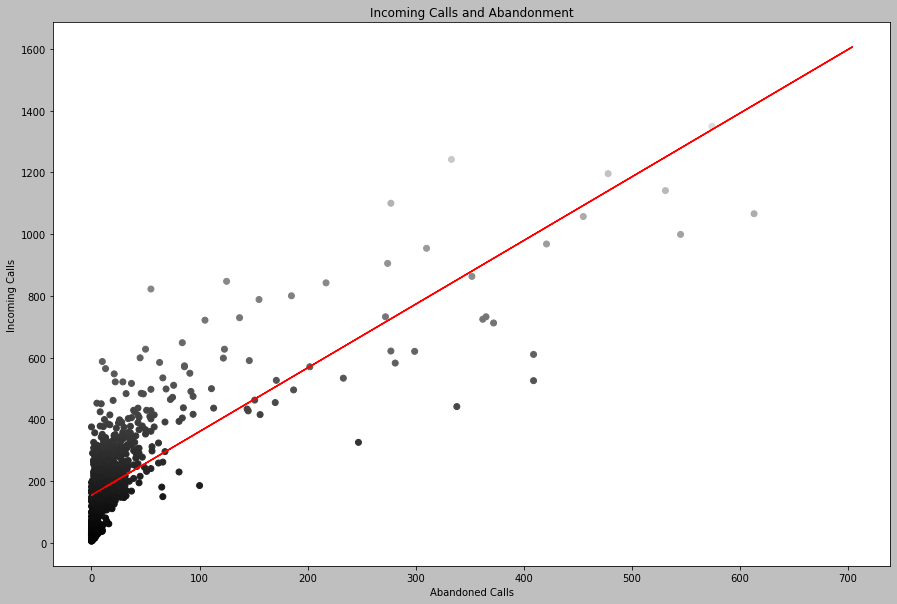

In [11]:
#Linear Regression - Incoming Calls and Abandonment 
x = np.array(ccd_time['Abandoned Calls']).reshape(-1,1)
y = np.array(ccd_time['Incoming Calls'])



mod = lr()
mod.fit(x,y)

mod = lr().fit(x,y)
r_sq = mod.score(x,y)

#print(r_sq)
#print(mod.intercept_)

y_pred = mod.predict(x)
#print(y_pred)

plt.figure(figsize=(15,10))
plt.scatter(x, y,c=y)
plt.plot(x, y_pred,c="red")
plt.xlabel('Abandoned Calls')
plt.ylabel('Incoming Calls')
plt.title('Incoming Calls and Abandonment')

[13.]
1.0


Text(0.5, 1.0, 'Actual vs. Predicted Abandonment')

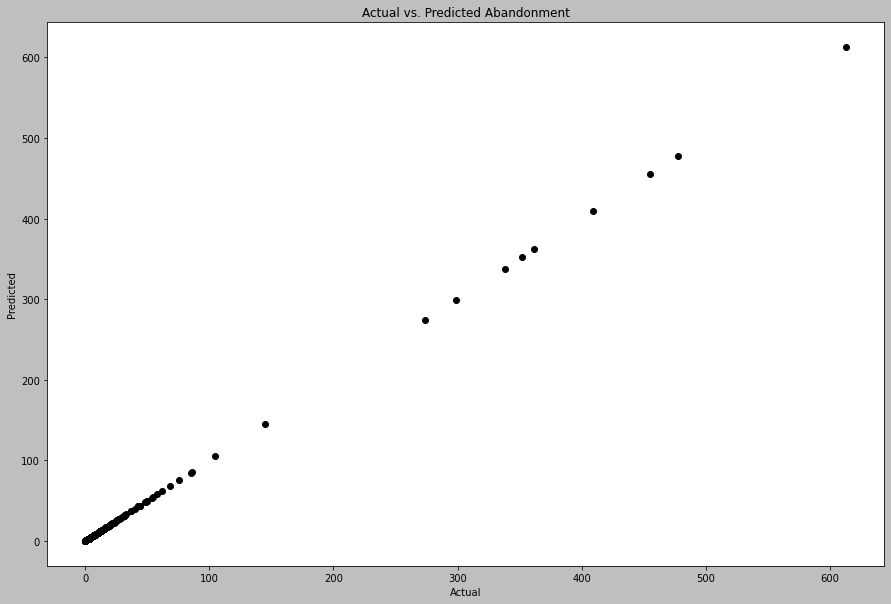

In [12]:
#Multiple Regression Analysis - Abandoned Calls 
x1 = ccd_time.drop(['Abandoned Calls'],axis=1).values
y1 = ccd_time['Abandoned Calls'].values 


x_train, x_test,y_train, y_test = tts(x1,y1, test_size=0.2,random_state=0)
model = lr()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
#print(y_pred)

#Testing Model Accuracy 
pred2 = model.predict([[217,204,94.01,0.0,0.0,0.0,76.28]])
print(pred2)

from sklearn.metrics import r2_score
accuracy = r2_score(y_test,y_pred)
print(accuracy)

plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Abandonment')

Text(0, 0.5, 'Average Wait Time')

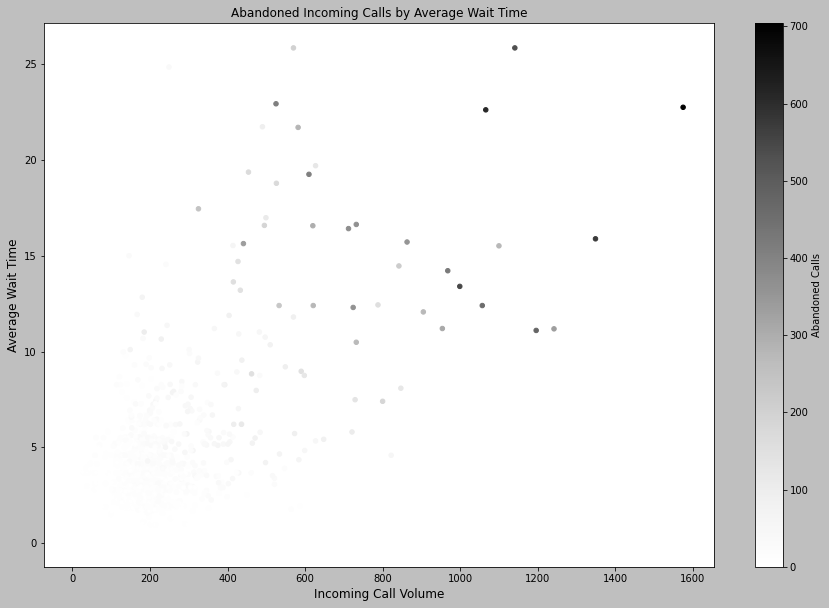

In [13]:
ccd_time.plot.scatter(x='Incoming Calls', y='Waiting Time (AVG)', c='Abandoned Calls', figsize=(15,10), title='Abandoned Incoming Calls by Average Wait Time', sharex=False)
plt.xlabel('Incoming Call Volume', size=12)
plt.ylabel('Average Wait Time', size=12)

Conversely, Service Level (SLA) and Average Speed of Answer (ASA) have an inverse relationship.  The below chart illustrates that as call volume increases, SLA decreases and ASA goes up.  In conjunction with the above graph, this clearly illustrates how these interact with high abandnment. 

<AxesSubplot:title={'center':'SLA, ASA, and Abandoned Calls'}, xlabel='Service Level (20 Seconds)', ylabel='Answer Speed (AVG)'>

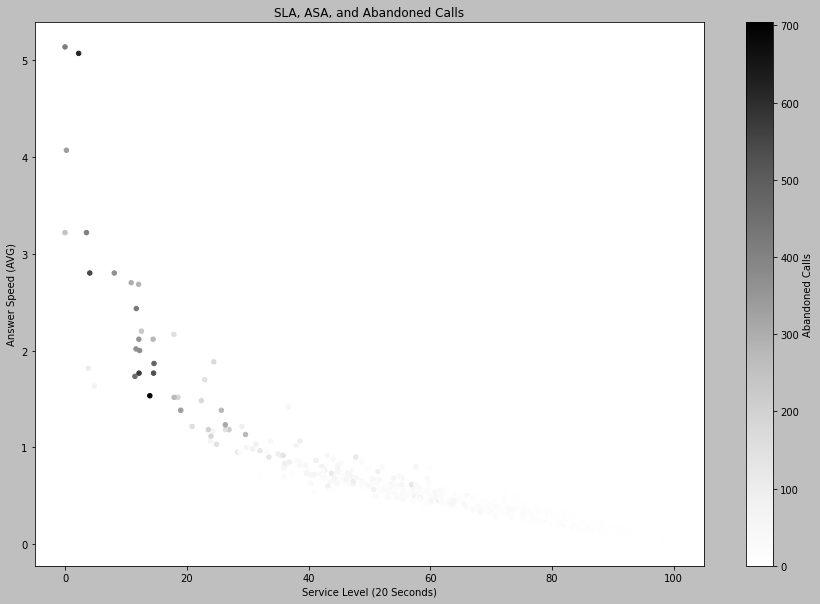

In [14]:

ccd_time.plot.scatter(x='Service Level (20 Seconds)', y='Answer Speed (AVG)', c='Abandoned Calls', figsize=(15,10), sharex=False,
                     title='SLA, ASA, and Abandoned Calls')


([], [])

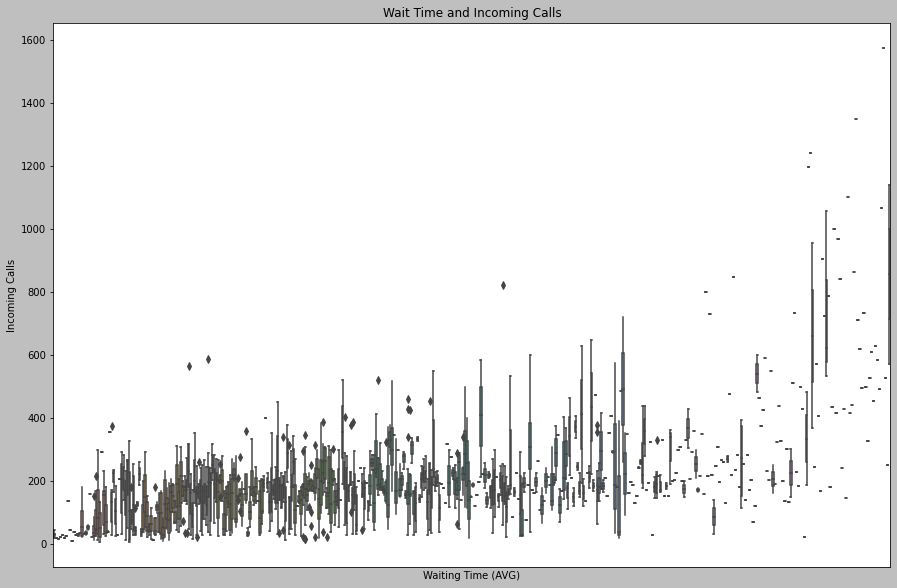

In [15]:
plt.figure(figsize=(15,10))
plt.title('Wait Time and Incoming Calls')
sns.boxplot(x=ccd_time['Waiting Time (AVG)'], y=ccd_time['Incoming Calls'])
plt.xticks([])



Fortunately, the vast majority of incoming calls are above 60% SLA.  At a 60% SLA, the average call is answered in less than 1 minute.  Combining the data from the below and above graphs, this means virtually no calls are being abandoned at a 60% SLA, although ancillary impacts (i.e. customer experience) may be impacted although the call is not abandoned. 

Limitations of this dataset prevent a complete analysis of the impact of staffing and relationships with abandonment, volume, etc.  But based on findings, next steps would be to dig further (with an expanded data set) to determine root cause of calls falling beneath the 60% threshold, and determining acceptable business KPI's for this metric (SLA) to balance customer experience, staffing, and cost. 

Text(0.5, 1.0, 'Contacts By SLA')

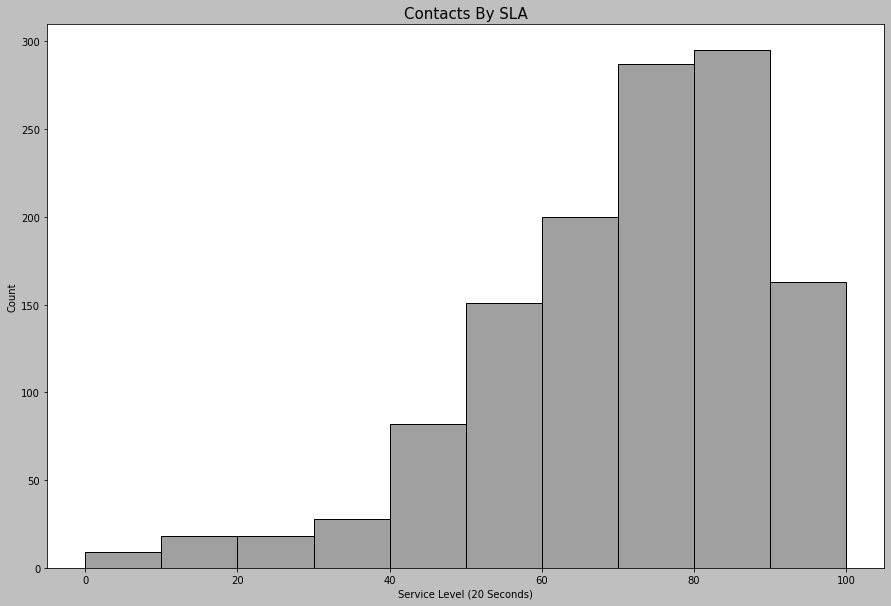

In [16]:
plt.figure(figsize=(15,10))
sns.histplot(ccd_time, x='Service Level (20 Seconds)', bins=10)
plt.title('Contacts By SLA', size=15)
